In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [2]:
def GA(N, K):
    if N == 4:
        tmp = [0, 1, 2, 3]
    elif N == 8:
        tmp = [0, 1, 2, 4, 3, 5, 6, 7]
    elif N == 16:
        tmp = [0, 1, 2, 4, 8, 3, 5, 6, 9, 10, 12, 7, 11, 13, 14, 15]
    return sorted(tmp[N-K:])

def NN_param(N, K):
    model = keras.models.load_model('./model/model_' + str(N) + '_' + str(K) + '.h5')
    tmp = model.get_weights()
    weights = []
    for i in range(int(len(tmp)/2)):
        weights.append(np.append([tmp[2*i+1]], tmp[2*i], axis=0))
    return weights

def encoder(u):
    N = len(u)
    if N == 1:
        x = u
    else:
        x1 = encoder(u[:int(N/2)])
        x2 = encoder(u[int(N/2):])
        x = np.append((x1+x2)%2, x2)
    return x

def decoder(y):
    tmp = y
    for i in NN[:-1]:
        tmp = np.dot(np.append(1, tmp), i)
        tmp[tmp < 0] = 0
    tmp = np.dot(np.append(1, tmp), NN[-1])
    tmp[tmp>0] = 1
    tmp[tmp<0] = 0
    return tmp

In [3]:
n = 4
N = 2**n
K = 4
R = K/N
free_set = GA(N, K)
NN = NN_param(N, K)

In [4]:
ebn0_min = 0
ebn0_max = 6
points = 13
ebn0 = np.linspace(ebn0_min, ebn0_max, points)

bsum = np.zeros(points, dtype=np.float64)
be = np.zeros(points, dtype=np.float64)
ber = np.zeros(points, dtype=np.float64)
fsum = np.zeros(points, dtype=np.float64)
fe = np.zeros(points, dtype=np.float64)
fer = np.zeros(points, dtype=np.float64)

times_min = 50000
times_max = 500000
error_max = 1000

In [5]:
for i in range(points):
    SNR = ebn0[i] + 10*np.log10(2*R)
    sigma = (1/10**(SNR/10))**(1/2)
    ii = 0
    
    while (fe[i] < error_max and ii < times_max) or (ii < times_min) :
#         u0 = np.random.randint(low=0, high=2, size=K, dtype=np.int8)
        u0 = np.ones(K, dtype=np.int8)
        u = np.zeros(N, dtype=np.int8)
        u[free_set] = u0
        x = encoder(u)
        
        y = 1 - 2*x + np.random.randn(N)*sigma
        
        u_pred = decoder(y)
        
        diff = np.sum((u_pred + u0)%2)
        fe[i] += bool(diff)
        be[i] += diff
        ii += 1

    fsum[i] = ii
    bsum[i] = ii*K
    fer[i] = fe[i]/fsum[i]
    ber[i] = be[i]/bsum[i]
    print(i, ii, fe[i])

0 50000 8565.0
1 50000 7003.0
2 50000 5373.0
3 50000 4124.0
4 50000 2908.0
5 50000 2029.0
6 50000 1336.0
7 57564 1000.0
8 102705 1000.0
9 191390 1000.0
10 377897 1000.0
11 500000 582.0
12 500000 270.0


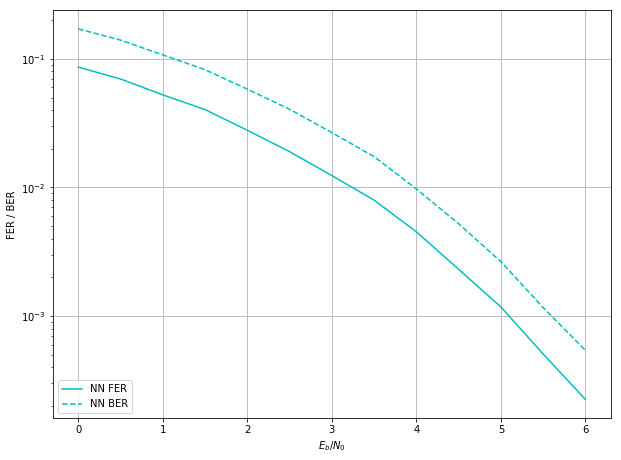

In [6]:
plt.figure(figsize=(10,7.5))
legend = ['NN FER', 'NN BER']

plt.plot(ebn0, ber, 'c') 
plt.plot(ebn0, fer, 'c--') 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('FER / BER')    
plt.grid(True)
plt.show()

In [7]:
d = pd.DataFrame([ebn0, ber, fer]).T
d.columns = ['ebn0', 'fer', 'ber']

In [8]:
d.to_csv('./data/NN_' + str(N) + '_' + str(K) + '.csv', index=False)